### ARIMA model forecast

In this task you should construct ARIMA model for a time series containing data about dynamics of mounthly wages in Russian Federation since 1993 year. You will train the best model (according to AIC criterion) on hystorical data and use it to make  forecast for the next 4 years.

Run the cells and fill necessary gaps.

Documentation on Statsmodels: https://www.statsmodels.org/stable/index.html

In [1]:
# let's import necassary packages...
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# let's load data...
WAG = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True,encoding='cp1251')
WAG

,WAG_C_M
month,
1993-05-01,37.5
1993-06-01,47.4
1993-07-01,56.0
1993-08-01,65.4
1993-09-01,80.9
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


In [ ]:
plt.figure(figsize(12,6))
WAG.plot()
plt.ylabel('Average nominal wage')
plt.xlabel('Months since January 1993')
pylab.show()

In [3]:
WAG.head(10)
print (WAG.shape)

(280, 1)


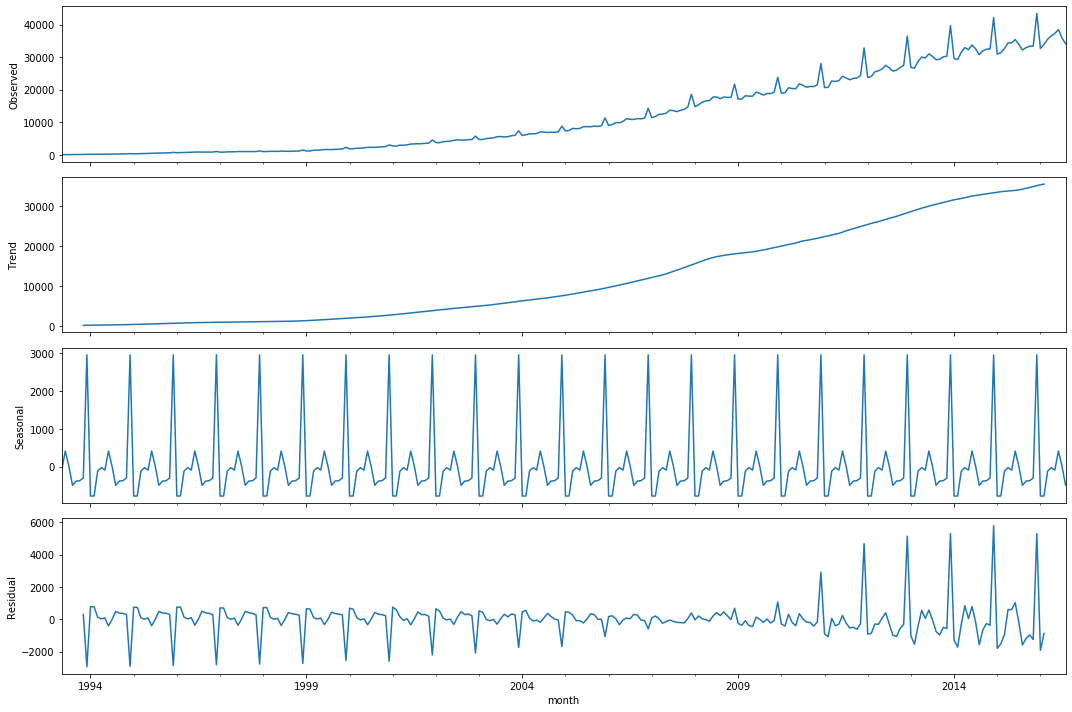

<Figure size 1080x720 with 0 Axes>

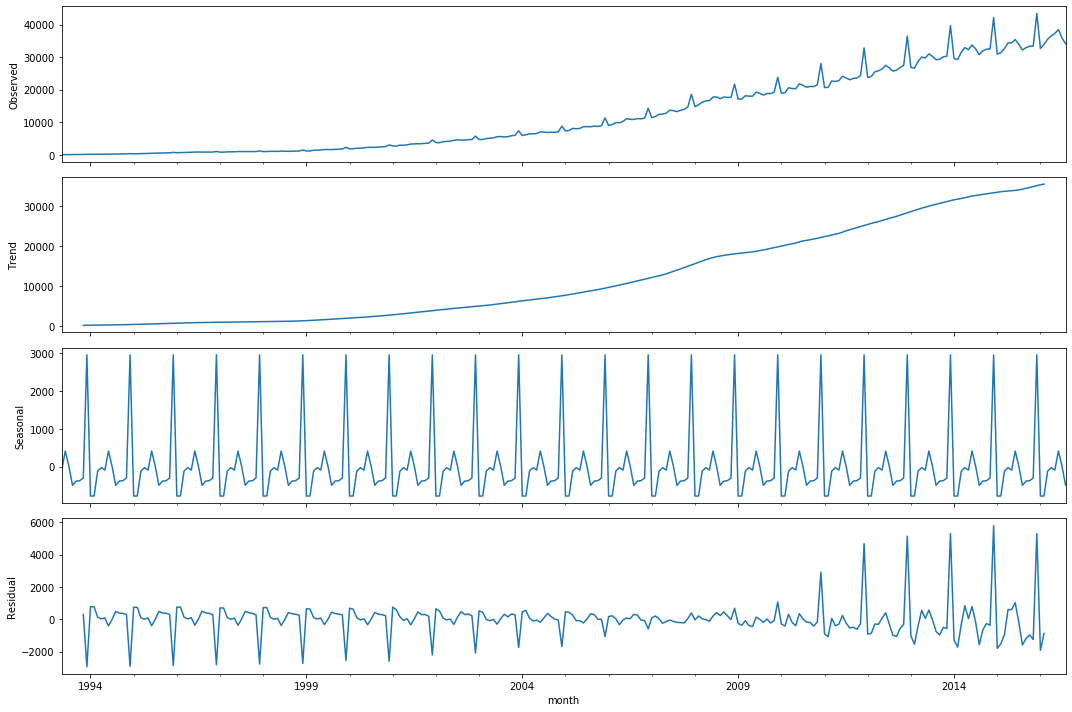

In [5]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M).plot()
#print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M)[1])

Best Box-Cox parameter: 0.257063
Dickey-Fuller test: p=0.688484


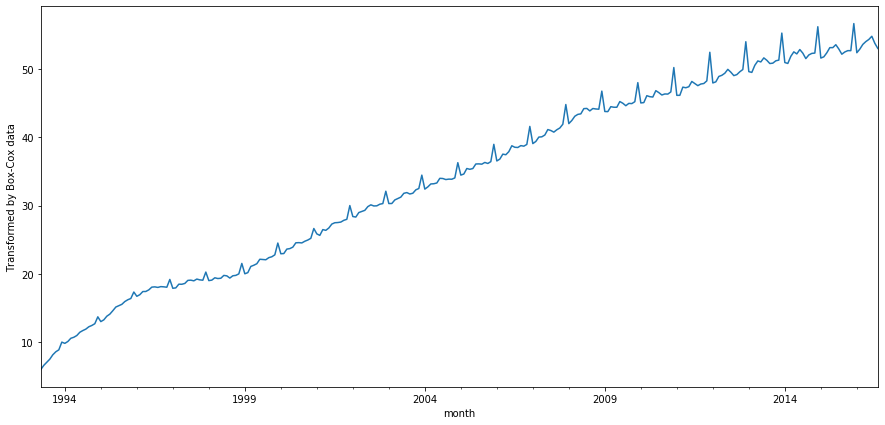

In [5]:
# Box-Cox transformation for dispersion stationarity

WAG['WAG_C_M_box'], lmbda = stats.boxcox(WAG.WAG_C_M)
plt.figure(figsize(15,7))
WAG.WAG_C_M_box.plot()
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box)[1])

In [18]:
WAG

,WAG_C_M,WAG_C_M_box,WAG_C_M_box_diff,WAG_C_M_box_diff2
month,,,,
1993-05-01,37.5,5.986007,NaN,NaN
1993-06-01,47.4,6.599071,NaN,NaN
1993-07-01,56.0,7.058410,NaN,NaN
1993-08-01,65.4,7.503958,NaN,NaN
1993-09-01,80.9,8.144275,NaN,NaN
...,...,...,...,...
2016-04-01,36497.0,54.019167,0.884016,0.884016
2016-05-01,37270.0,54.332006,1.195576,1.195576
2016-06-01,38447.0,54.799216,1.234663,1.234663


Dickey-Fuller test: p=0.033416


<Figure size 1080x720 with 0 Axes>

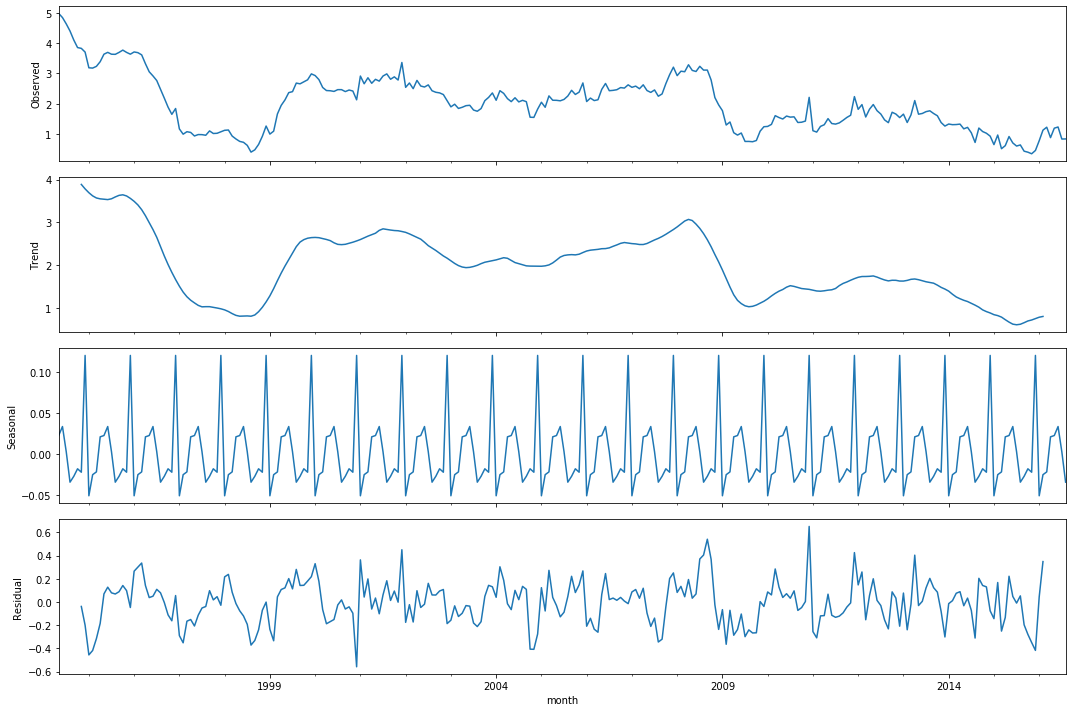

In [39]:
# seasonal difference for 12 months

WAG['WAG_C_M_box_diff'] = WAG.WAG_C_M_box - WAG.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff[12:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff[12:])[1])

Dickey-Fuller test: p=0.000001


<Figure size 1080x720 with 0 Axes>

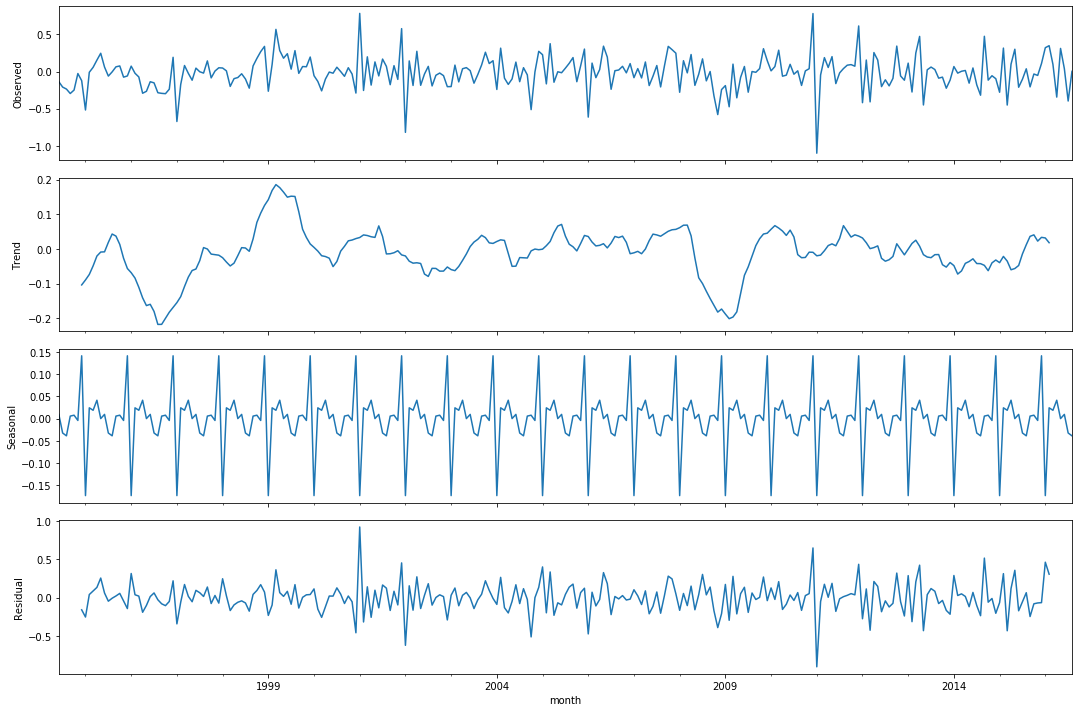

In [40]:
# CODE 1
# Make additional 1-step difference by analogy with previous cell and evaluate Dickey-Fuller p-value
# Did the data become more stationary?
WAG['WAG_C_M_box_diff2'] = WAG.WAG_C_M_box_diff - WAG.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff2[13:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff2[13:])[1])

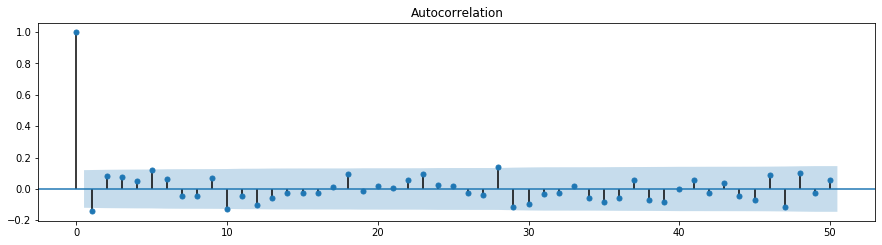

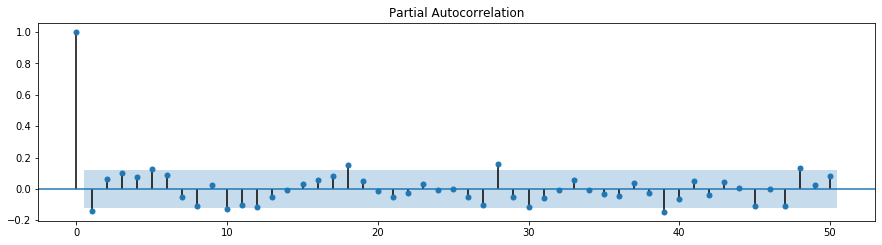

In [41]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize(15,8))

# autocorrelation 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Нач приближения Q=0,q=2,P=1,p=2

In [58]:
# CODE 2
# Choose parameters for SARIMA model based on Autocorrelation and Partial Autocorrelation graphs

ps = range(0, 3)
d  = 1
qs = range(0, 3)
Ps = range(0, 2)
S=12
D  = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 18


In [59]:
# here we will choose the best model

#%%time
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [60]:
# Top models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters        aic
9  (2, 2, 1, 0) -49.074862
8  (2, 2, 0, 0) -49.021113
7  (1, 2, 1, 0) -36.847134
6  (1, 2, 0, 0) -33.665077
5  (1, 0, 1, 0) -30.710019


In [61]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  280
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood                  30.537
Date:                            Sun, 10 May 2020   AIC                            -49.075
Time:                                    18:35:21   BIC                            -27.551
Sample:                                05-01-1993   HQIC                           -40.429
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4660      0.052     27.962      0.000       1.363       1.569
ar.L2         -0.6625      0.053   

Student test: p=0.292906
Dickey-Fuller test: p=0.0000000000000000000000000


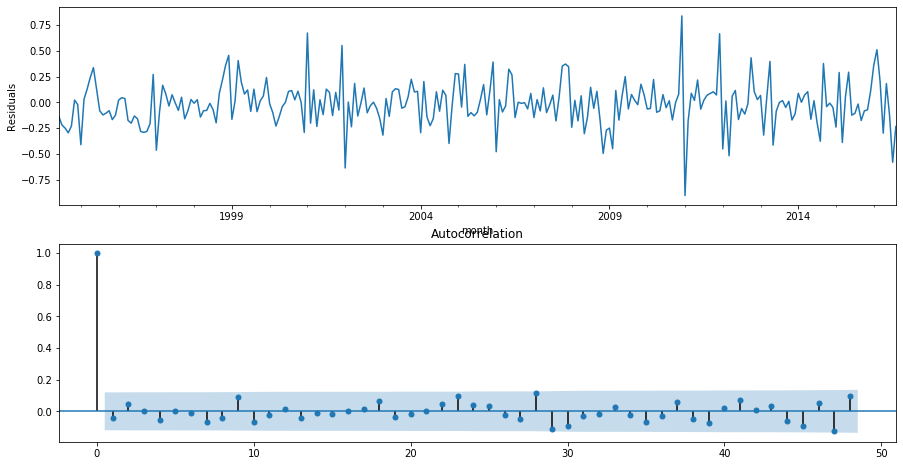

In [62]:
# evaluate Dickey-Fuller test for the best model

plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [63]:
#inverse Box-Cox transformation:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)

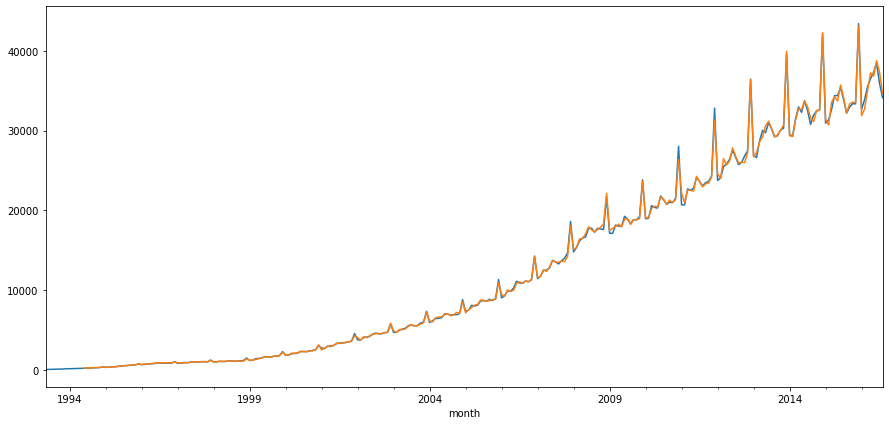

In [65]:
# CODE 3
# Plot the best model and original time series on the same figure
plt.figure(figsize(15,7))
WAG.WAG_C_M.plot()
WAG.model[13:].plot()
plt.show()
#plt.plot(-fit by best model-)

In [70]:
# CODE 4
# Evaluate the MAPE metric to check  best model's performance
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE = mean_absolute_percentage_error(WAG.WAG_C_M[13:],WAG.model[13:])
MAPE

1.7546113583785197

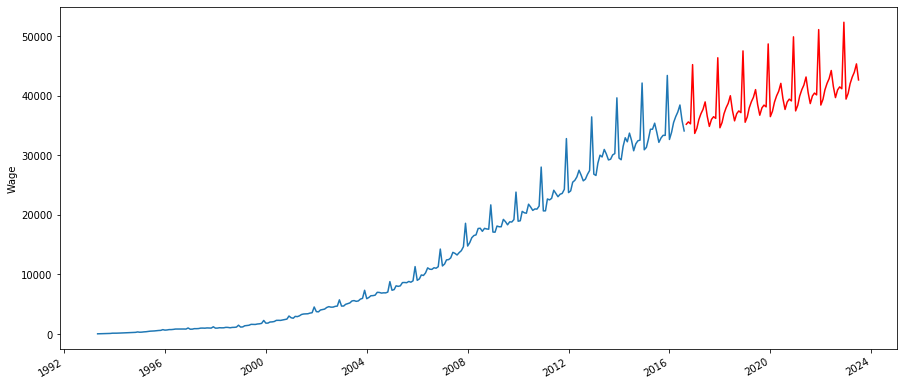

In [67]:
# CODE 5
# Make the forecast until 2021 year. Fill the None's: 

WAG2 = WAG[['WAG_C_M']]
#
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,84)]
#
future = pd.DataFrame(index=date_list, columns= WAG2.columns)
WAG2 = pd.concat([WAG2, future])
#
WAG2['forecast'] = invboxcox(best_model.predict(start=280, end=363), lmbda)
#

plt.figure(figsize(15,7))
WAG2.WAG_C_M.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()